In [1]:
#require "jupyter.notebook"
#require "juplot"
#directory "_build/balanced_network"
#load "lib.cmo"
let _ = Jupyter_notebook.clear_output ()

- : unit = ()


In [2]:
let dt = 1E-3
let n = 1000
let rx = 20.0

val dt : float = 0.001


val n : int = 1000


val rx : float = 20.


In [3]:
module X = Lib.Poisson_population (struct
    let n = n
    let rate = rx
    let dt = dt
end)

module X : sig val step : unit -> unit val spikes : unit -> int array end


## Test the Poisson population

In [6]:
let plot_raster raster color (module F: Gp.Figure) =
    F.barebone ();
    F.set Label (`y, "neurons");
    F.set Range (`y, (0.0, 100.0));
    F.ex "set object 1 rectangle \
          from first 0, graph -0.1 rto first 0.2, graph 0.05 \
          fs solid 1.0 fc rgb 'black' noclip";
    F.plot [| [Mat.col raster 0; Mat.col raster 1], Printf.sprintf "u 1:2 w p pt 7 lc rgb '%s' ps 0.4" color |]

val plot_raster : Owl.Mat.mat -> string -> (module Gp.Figure) -> unit = <fun>


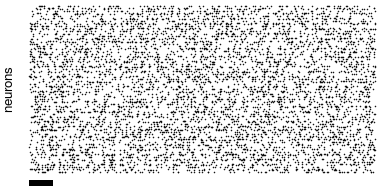

- : unit = ()


In [5]:
let _ =
    let d = 3. in
    let raster =
        Array.init (int_of_float (d /. dt)) (fun t -> X.step (); X.spikes ())
        |> Lib.plottable_raster ~dt in
    Juplot.draw ~fmt:`png ~size:(400,200) (plot_raster raster "#cc000000")

## Fully connected E/I

In [ ]:
module Prms = struct
    let n = n
    let dt = dt
    let free_vm = false
    let tau = 20E-3
    let threshold = 1.0
end

module E = Lib.LIF_population (Prms)
module I = Lib.LIF_population (Prms)

In [ ]:
let k = 100
let z = 1. /. sqrt (float k)

let inputs jx je ji = [
      z *. jx, Lib.random_synapses n n k, X.spikes;
      z *. je, Lib.random_synapses n n k, E.spikes;
      z *. ji, Lib.random_synapses n n k, I.spikes ]

let inputs_e = inputs 1. 1. (-2.)
let inputs_i = inputs 0.8 1.0 (-1.8)

In [ ]:
let _ =
    Jupyter_notebook.clear_output ();
    let id = Jupyter_notebook.display_formatter "text/html" in
    let d = 3. in
    let rasters = Array.init (int_of_float (d /. dt)) (fun t ->
        if t mod 10 = 0 then begin
            Jupyter_notebook.printf "\rt=%5.3f%!" (dt *. float t);
            Jupyter_notebook.display_formatter ~display_id:id "text/html" |> ignore;
        end;
        X.step ();
        E.step inputs_e;
        I.step inputs_i;
        X.spikes (), E.spikes (), I.spikes ()) in
    let raster extract = rasters |> Array.map extract |> Lib.raster_of dt in
    Juplot.draw ~fmt:`png ~size:(200,500) (fun (module F: Gp.Figure) ->
        F.multiplot (3,1) (fun i j k ->
            let extract (a, b, c) = if i=0 then a else if i=1 then b else c in
            let color = if i=0 then "black" else if i=1 then "red" else "blue" in
            plot_raster (raster extract) color (module F)
    ))

---

In [ ]:
let time_this f =
    let t0 = Unix.gettimeofday () in
    let result = f () in
    let t1 = Unix.gettimeofday () in
    t1 -. t0, result

In [ ]:
let _ =
    Jupyter_notebook.clear_output ();
    let id = Jupyter_notebook.display_formatter "text/html" in
    for t=0 to 1 do
        Unix.sleep 1;
        Jupyter_notebook.printf "\rt=%5i%!" t;
        Jupyter_notebook.display_formatter ~display_id:id "text/html";
    done